In [1]:
from __future__ import division, print_function
import sys
import os
%pylab notebook
lib_path = '/home/fgeigl/navigability_of_networks'
sys.path.append(lib_path)
lib_path = '/home/fgeigl/navigability_of_networks/tools'
sys.path.append(lib_path)
import network_matrix_tools
import numpy as np
from scipy.sparse import csr_matrix, diags
import pandas as pd
import datetime
from scipy.sparse.csgraph import connected_components
from collections import Counter
import operator
from sklearn.preprocessing import normalize
import numba
from joblib import Parallel, delayed
from math import sqrt
import random
import seaborn

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
df_fname = 'click_stream_results_poweriter_10k_p10.df'
df = pd.read_pickle(df_fname)
print(df.head(2))

   beta_0.001  beta_0.005  beta_0.01  beta_0.05  beta_0.1  beta_0.25  \
0    0.000600    0.001678   0.003238   0.009166  0.010187   0.010048   
1    0.001654    0.004640   0.008991   0.026075  0.029554   0.030135   

   beta_0.5  beta_0.75  beta_1.0      A_sd  
0  0.009503   0.009117  0.008835  0.006229  
1  0.029195   0.028282  0.027493  0.014659  


In [3]:
test_ser = list(df['beta_0.05'])
num_samples = 100
results = list()
for i in [0.001, 0.01] + list(np.arange(0.1, 1.1, 0.1)):
    num_elements = int(np.round(len(test_ser) * i))
    print(i, ':', num_elements)
    if num_elements == 0:
        continue
    sample_res = list()
    for j in range(num_samples):
        if num_elements == len(test_ser):
            rnd_sample = test_ser
        else:
            rnd_sample = random.sample(test_ser, num_elements)
        assert len(rnd_sample) == num_elements
        perc_low = np.percentile(rnd_sample, 25)
        med = np.median(rnd_sample)
        perc_high = np.percentile(rnd_sample, 75)
        sample_res.append((perc_low, med, perc_high))
    sample_res = zip(*sample_res)
    assert np.allclose(num_samples, map(len, sample_res))
    perc_low, med, perc_high = map(np.mean, sample_res)
    perc_low_std, med_std, perc_high_std = map(np.std, sample_res)
    results.append((i, perc_low, med, perc_high, perc_low_std, med_std, perc_high_std))
print('done.')

0.001 : 2140
0.01 : 21404
0.1 : 214042
0.2 : 428085
0.3 : 642127
0.4 : 856169
0.5 : 1070212
0.6 : 1284254
0.7 : 1498296
0.8 : 1712338
0.9 : 1926381
1.0 : 2140423


KeyboardInterrupt: 

done


<IPython.core.display.Javascript object>


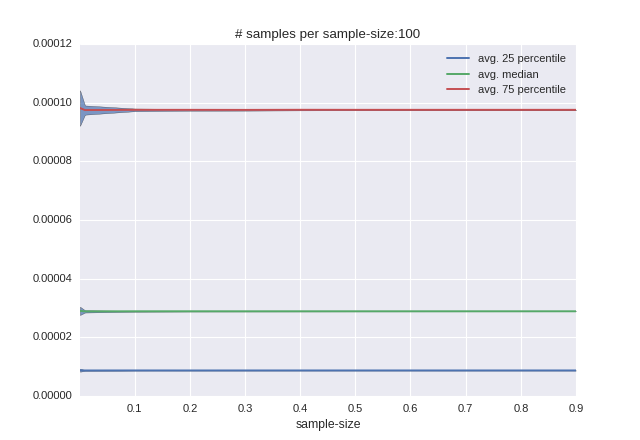

In [4]:
res_df = pd.DataFrame(columns=['sample-size', 'avg. 25 percentile', 'avg. median', 'avg. 75 percentile', 'l_std', 'm_std', 'h_std'], data=results)
print('done')
y = ['avg. 25 percentile', 'avg. median', 'avg. 75 percentile']
y_err = ['l_std', 'm_std', 'h_std']
ax = res_df.plot(x='sample-size', y=y)
for i, j in zip(y_err, y):
    ax.fill_between(res_df['sample-size'], res_df[j] + res_df[i], res_df[j] - res_df[i], alpha=0.7)
plt.title('# samples per sample-size:' + str(num_samples))